<a href="https://colab.research.google.com/github/EsraaaMohammed/Selected-Project_Phase1/blob/main/Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mean Accuracy across folds: 0.9701
Mean ROC AUC across folds: 0.9919


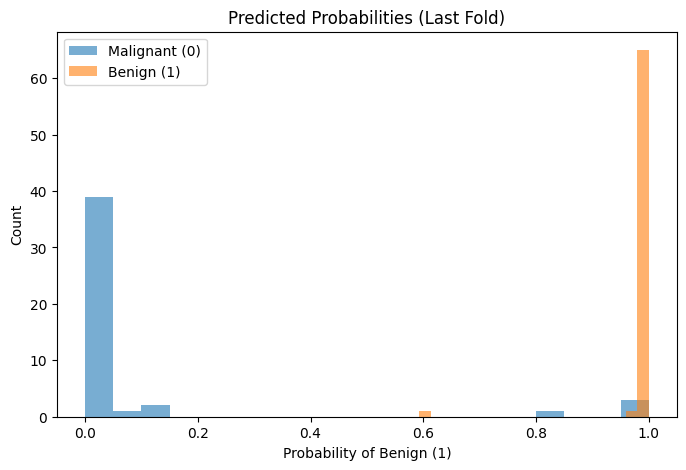

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score

# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Preprocess: Impute and scale
X = SimpleImputer(strategy='mean').fit_transform(X)
X = StandardScaler().fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define the neural network with sigmoid at the output
class BinaryANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Sigmoid()  # Explicit Sigmoid here
        )

    def forward(self, x):
        return self.model(x)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, auc_scores = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

    model = BinaryANN(input_dim=X.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()  # Use BCELoss since we have Sigmoid

    # Training loop
    model.train()
    for _ in range(500):
        probs = model(X_train)
        loss = criterion(probs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        probs = model(X_test).numpy()
        preds = (probs > 0.5).astype(int)

    y_true = y_test.numpy()
    acc_scores.append(accuracy_score(y_true, preds))
    auc_scores.append(roc_auc_score(y_true, probs))

    if fold == kf.get_n_splits() - 1:
        final_probs = probs
        final_preds = preds
        final_true = y_true

print(f"Mean Accuracy across folds: {np.mean(acc_scores):.4f}")
print(f"Mean ROC AUC across folds: {np.mean(auc_scores):.4f}")

plt.figure(figsize=(8, 5))
plt.hist(final_probs[final_true == 0], bins=20, alpha=0.6, label="Malignant (0)")
plt.hist(final_probs[final_true == 1], bins=20, alpha=0.6, label="Benign (1)")
plt.title("Predicted Probabilities (Last Fold)")
plt.xlabel("Probability of Benign (1)")
plt.ylabel("Count")
plt.legend()
plt.show()
